In [1]:
import numpy as np
import pandas as pd
import os, sys
import PIL.Image
import torch
import h5py
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import scipy.stats, scipy.spatial.distance

root = '/mnt/neurocube/local/serenceslab/maggie/shapeDim/'
feat_dir = os.path.join(root, 'Analysis', 'image_similarity', 'features')
image_dir = os.path.join(root, 'Stimuli','AmpGrid3_adj_full_grey_small')

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import grid_utils

In [2]:

f = []
    
fn = os.path.join(feat_dir, 'gist', 'Images_grid3_gistdescriptors_4ori_4blocks.h5py')
print(fn)
with h5py.File(fn, 'r') as file:
    
    f = np.array(file['/features'])
    file.close()

fz = scipy.stats.zscore(f, axis=0)

/mnt/neurocube/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/gist/Images_grid3_gistdescriptors_4ori_4blocks.h5py


In [3]:
from sklearn import decomposition
pca = decomposition.PCA(n_components = 100, copy=True)
scores = pca.fit_transform(f)    

In [4]:
labs = pd.read_csv(os.path.join(feat_dir, 'Image_labels_grid3.csv'))

pts = np.array([labs['coord_axis1'], labs['coord_axis2']]).T

main_grid = grid_utils.get_main_grid()
gi = [np.argmin(np.sum((pts-g)**2, axis=1)) for g in main_grid]

f_main = f[gi,:]
scores_main = scores[gi,:]
pts[gi,:]

array([[0.1, 0.1],
       [1.7, 0.1],
       [3.3, 0.1],
       [4.9, 0.1],
       [0.1, 1.7],
       [1.7, 1.7],
       [3.3, 1.7],
       [4.9, 1.7],
       [0.1, 3.3],
       [1.7, 3.3],
       [3.3, 3.3],
       [4.9, 3.3],
       [0.1, 4.9],
       [1.7, 4.9],
       [3.3, 4.9],
       [4.9, 4.9]])

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

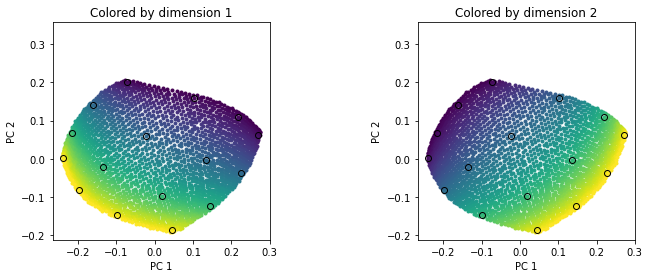

In [9]:
viridis = cm.get_cmap('viridis')
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
grid_x = np.unique(labs['coord_axis1'])

cols2plot = viridis(np.linspace(0,1,len(grid_x)))

for ii in range(len(grid_x)):
    inds2plot = np.where(labs['coord_axis1']==grid_x[ii])[0]
    plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])

plt.plot(scores_main[:,0], scores_main[:,1], 'o', color='k', markerfacecolor='none')

plt.axis('square');
# plt.xticks([]);
# plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Colored by dimension 1');

grid_y= np.unique(labs['coord_axis2'])

cols2plot = viridis(np.linspace(0,1,len(grid_y)))
plt.subplot(1,2,2)
for ii in range(len(grid_y)):
    inds2plot = np.where(labs['coord_axis2']==grid_y[ii])[0]
    plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])
    
plt.plot(scores_main[:,0], scores_main[:,1], 'o', color='k', markerfacecolor='none')
plt.axis('square');
# plt.xticks([]);
# plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Colored by dimension 2');

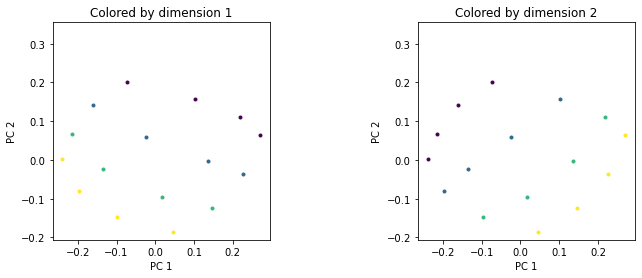

In [11]:
viridis = cm.get_cmap('viridis')
grid = np.unique(main_grid[:,0])

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

cols2plot = viridis(np.linspace(0,1,len(grid)))

for ii in range(len(grid)):
    inds2plot = np.where(main_grid[:,0]==grid[ii])[0]
    plt.plot(scores_main[inds2plot,0],scores_main[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
# plt.xticks([]);
# plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Colored by dimension 1');


plt.subplot(1,2,2)

for ii in range(len(grid)):
    inds2plot = np.where(main_grid[:,1]==grid[ii])[0]
    plt.plot(scores_main[inds2plot,0],scores_main[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
# plt.xticks([]);
# plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Colored by dimension 2');

In [12]:
acc_eachaxis = np.zeros([3,])

on_bound = np.any(np.array([labs['labels_task%d'%axis] for axis in [1,2,3]]).T==0, axis=1)
inds_use = ~on_bound

for ai, axis in enumerate([1,2,3]):

    x = fz[inds_use]
    y = np.array(labs['labels_task%d'%axis]).astype(int)[inds_use]

    n_cv = 10
    n_tot = x.shape[0]
    n_each = int(np.ceil(n_tot/n_cv))
    cvl = np.tile(np.arange(n_cv), [n_each,])[0:n_tot]

    y_pred = np.zeros_like(y)

    for cv in np.unique(cvl):

        trninds = cvl!=cv
        tstinds = cvl==cv
        print(np.sum(trninds), np.sum(tstinds))

        model = sklearn.linear_model.LogisticRegression(C=0.05, \
                                                    multi_class='multinomial',\
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = 8 , \
                                                    max_iter = 1000)
        x_trn = x[trninds,:]
        y_trn = y[trninds]
        print(np.unique(y_trn, return_counts=True))
        x_tst = x[tstinds,:]

        model.fit(x_trn,y_trn)

        pred = model.predict(x_tst)

        y_pred[tstinds] = pred
        
    acc_eachaxis[ai] = np.mean(y==y_pred)

2250 250
(array([1, 2]), array([1100, 1150]))
2250 250
(array([1, 2]), array([1100, 1150]))
2250 250
(array([1, 2]), array([1100, 1150]))
2250 250
(array([1, 2]), array([1100, 1150]))
2250 250
(array([1, 2]), array([1100, 1150]))
2250 250
(array([1, 2]), array([1150, 1100]))
2250 250
(array([1, 2]), array([1150, 1100]))
2250 250
(array([1, 2]), array([1150, 1100]))
2250 250
(array([1, 2]), array([1150, 1100]))
2250 250
(array([1, 2]), array([1150, 1100]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([1125, 1125]))
2250 250
(array([1, 2]), array([11

In [14]:
acc_eachaxis

array([0.9984, 1.    , 0.9868])

In [13]:
sep_eachaxis = np.zeros((3,))

for ai, axis in enumerate([1,2,3]):


    l = np.array(labs['labels_task%d'%axis])[gi].astype(int)

    group1 = f_main[l==1,:]
    group2 = f_main[l==2,:]
    
    within1 = scipy.spatial.distance.pdist(group1)
    within2 = scipy.spatial.distance.pdist(group2)
    
    cat = np.concatenate([group1, group2], axis=0)
     
    between = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(cat))
    between = between[0:8,8:]
    between = between.ravel()
    
    b = np.mean(between)
    w = np.mean(np.concatenate([within1, within2], axis=0))
    sep =  (b-w) / (b+w)
    
    sep_eachaxis[ai] = sep
    
sep_eachaxis

array([0.14044268, 0.18939077, 0.01392477])